## **Qmio Error Analysis.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qmioanalyzer import read_data, ErrorAnalyzer, ErrorVisualizer

# plt.rcParams.update(plt.rcParamsDefault)
# #plt.rcParams["figure.figsize"] = [8.0, 5.50]
# plt.rcParams["figure.autolayout"] = True
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.size'] = 11
# plt.rcParams['font.family'] = "serif"

In [2]:
output_graphs = False

### **1. $T_1$ measurements**

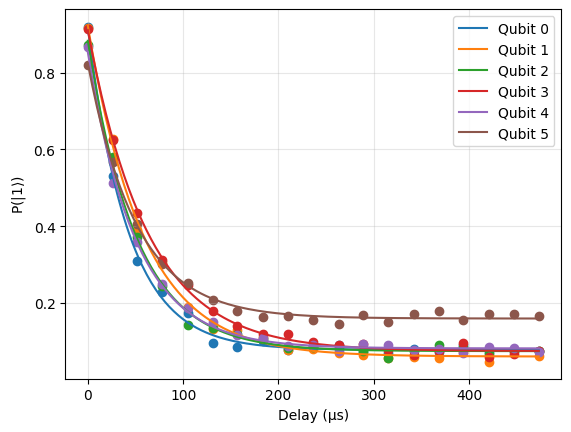

Qubit 0: T1 = 42.52 µs
Qubit 1: T1 = 57.99 µs
Qubit 2: T1 = 50.87 µs
Qubit 3: T1 = 63.02 µs
Qubit 4: T1 = 50.14 µs
Qubit 5: T1 = 51.15 µs


In [3]:
# load results
data = pd.read_csv("data/t1_qmio_results2.csv")

# define the exponential model
def exp_decay(t, A, T1, B):
    return A * np.exp(-t / T1) + B

t1_values = {}

for qubit in data["qubit"].unique():
    qubit_data = data[data["qubit"] == qubit]
    t = qubit_data["delay_us"].values
    p1 = qubit_data["p1"].values
    
    # initial guesses: A=1, T1=100, B=0
    popt, pcov = curve_fit(exp_decay, t, p1, p0=[1.0, 100.0, 0.0])
    A, T1, B = popt
    t1_values[qubit] = T1
    
    # plot fit
    t_fit = np.linspace(min(t), max(t), 200)
    plt.scatter(t, p1)
    plt.plot(t_fit, exp_decay(t_fit, *popt), label=f"Qubit {qubit}")

plt.xlabel("Delay (µs)")
plt.ylabel(r"P($|1\rangle$)")
plt.legend()
plt.grid(alpha = 0.3)
if output_graphs:   
    plt.savefig("T1_fits.pdf", format='pdf')
plt.show()


# print extracted T1s
for q, T1 in t1_values.items():
    print(f"Qubit {q}: T1 = {T1:.2f} µs")

### **2. $T_2^*$ measurements**

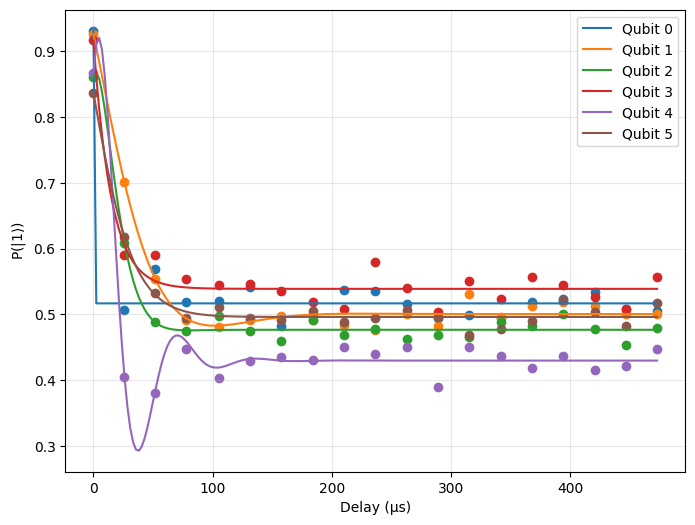

Qubit 0: T2* = 0.26 µs
Qubit 1: T2* = 36.02 µs
Qubit 2: T2* = 12.92 µs
Qubit 3: T2* = 15.00 µs
Qubit 4: T2* = 25.87 µs
Qubit 5: T2* = 16.31 µs


In [4]:
data = pd.read_csv("data/t2_qmio_results2.csv")

# --- Define exponential decay function for Ramsey (centered at 0.5) ---
def ramsey_osc(t, A, B, T2, Delta, phi):
    return A + B * np.sin(2*np.pi*Delta*t + phi) * np.exp(-t/T2)


# Dictionary to store T2* for each qubit
t2_values = {}

plt.figure(figsize=(8,6))

for qubit in data["qubit"].unique():
    qubit_data = data[data["qubit"] == qubit]
    t = qubit_data["delay_us"].values
    p1 = qubit_data["p1"].values
    
    # initial guess: A=0.5, T2=100, B=0.5
    popt, pcov = curve_fit(
        ramsey_osc, t, p1, 
        p0=[0.5, 0.5, 200, 0.01, 0],   # better initial guesses
        bounds=([0, 0, 0, 0, -np.pi], [1, 1, np.inf, 0.1, np.pi])
    )
    A, B, T2, Delta, phi = popt
    t2_values[qubit] = T2
    
    # smooth fit line
    t_fit = np.linspace(min(t), max(t), 200)
    plt.scatter(t, p1)
    plt.plot(t_fit, ramsey_osc(t_fit, *popt), label=f"Qubit {qubit}")

plt.xlabel("Delay (µs)")
plt.ylabel(r"P($|1\rangle$)")
#plt.title("Ramsey experiment: T2* extraction")
plt.legend()
plt.grid(alpha = 0.3)
if output_graphs:  
    plt.savefig("T2star_fits.pdf", format='pdf')
plt.show()

# print extracted T2* values
for q, T2 in t2_values.items():
    print(f"Qubit {q}: T2* = {T2:.2f} µs")

## **Low period circuit.**

### **3. Error distributions.**

In [5]:
bits, rep, init, backend, extra = read_data("data/results_cosmic_3.txt")

In [6]:
print("Bitstrings:", bits[:5])     # first 5 measured states
print("Repetition period:", rep)
print("Init state:", init)
print("Backend:", backend)
print("Batch IDs:", extra.get("batch"))
print("Shot IDs:", extra.get("shot"))
print("Abs times:", extra.get("abstime"))


Bitstrings: ['001011' '000100' '010111' '010101' '110011']
Repetition period: 1.5e-05
Init state: None
Backend: qmio
Batch IDs: [  1   1   1 ... 815 815 815]
Shot IDs: [      1       2       3 ... 6676478 6676479 6676480]
Abs times: [  1.185189   1.185189   1.185189 ... 954.625391 954.625391 954.625391]


In [7]:
errors_obj = ErrorAnalyzer(repetition_period = rep, init_state = init, measurements = bits, verbose=2)
errors_dict = errors_obj.get_errors()

The analysis was performed using the *low repetition period* approach 
(repetition_period < 5e-10 μs). The error dictionary contains:

- Key: 'low_period_errors' → A dictionary with 6676479 measurements with the following subkeys:
  - 'true_errors': Array with the number of true errors (0 expected, 1 measured) for each measurement.
  - 'false_errors': Array with the number of false errors (1 expected, 0 measured) for each measurement.
  - 'total_errors': Array with the total number of errors for each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).




In [8]:
states = errors_dict["low_period_errors"]["states"]
expected = errors_dict["low_period_errors"]["expected"]
true_errors = errors_dict['low_period_errors']['true_errors']
false_errors = errors_dict['low_period_errors']['false_errors']
total_errors = errors_dict['low_period_errors']['total_errors']
times = errors_dict['low_period_errors']['times']


print('number of true errors:',sum(true_errors))
print('number of false errors:',sum(false_errors))
print('number of total errors:',sum(total_errors))


number of true errors: 11134021
number of false errors: 4707769
number of total errors: 15841790


In [9]:
print(times[:5], times[-5:])
print(extra.get("abstime")[1:5], extra.get("abstime")[-5:])

[0.0, 1.5e-05, 3e-05, 4.5e-05, 6e-05] [100.14711, 100.147125, 100.14714000000001, 100.147155, 100.14717]
[1.185189 1.185189 1.185189 1.185189] [954.625391 954.625391 954.625391 954.625391 954.625391]


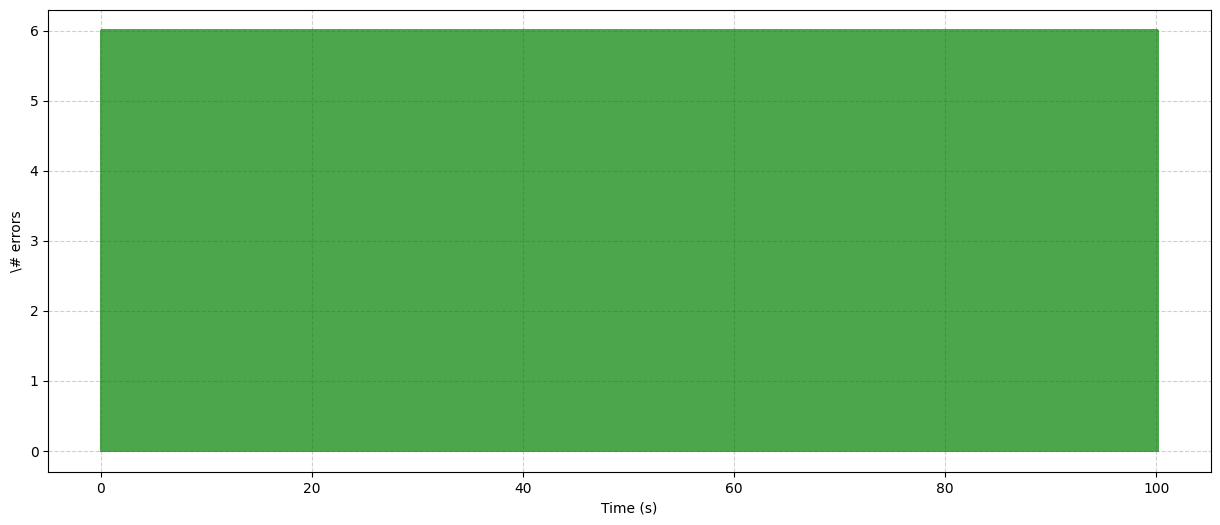

In [10]:
plt.figure(figsize=(15,6))
plt.plot(times, total_errors, '-', color = 'green', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel(r"\# errors")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

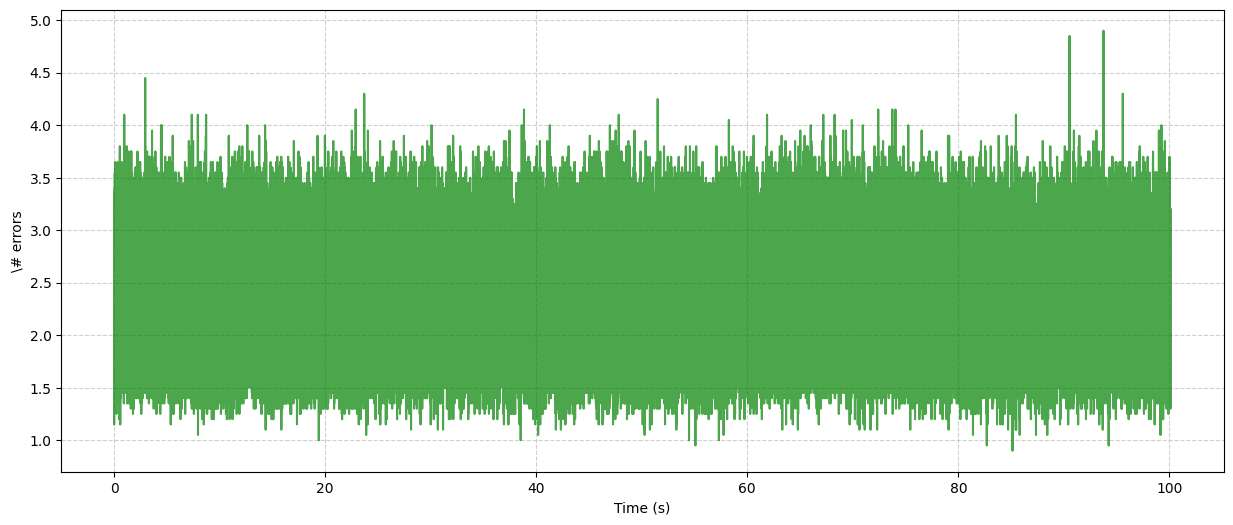

In [11]:
# Example: group every 6 points
bin_size = 20

# convert to arrays
times = np.array(times)
total_errors = np.array(total_errors)

# number of full bins
n_bins = len(total_errors) // bin_size

# reshape and take mean
binned_times = times[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)
binned_errors = total_errors[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)

# plot
plt.figure(figsize=(15,6))
plt.plot(binned_times, binned_errors, '-', color='green', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel(r"\# errors")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

mean number of errors: 2.372777939207304


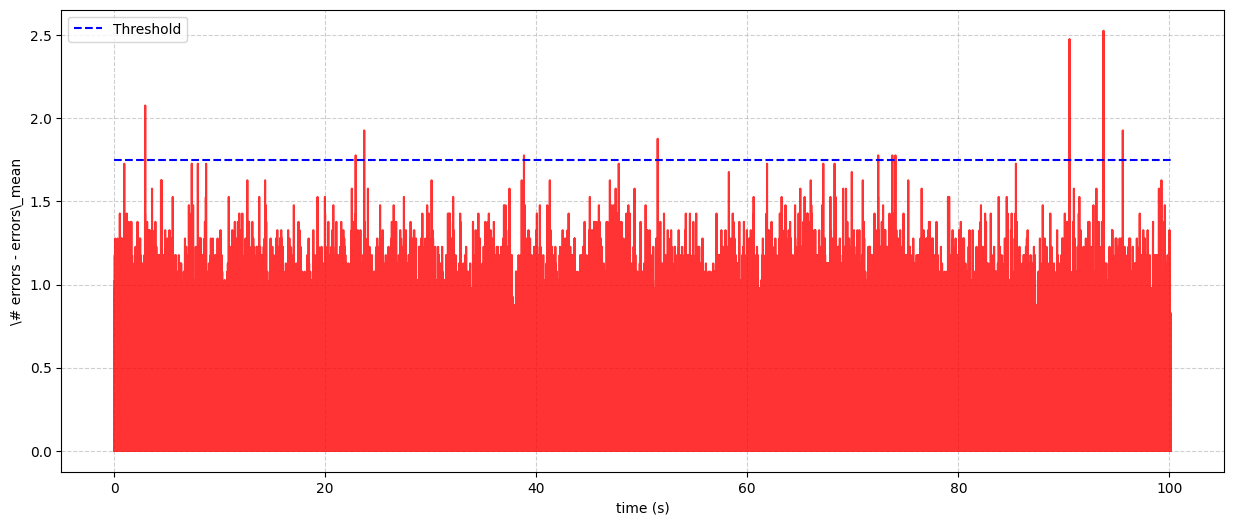

In [12]:
# assume binned_times, binned_errors from previous step
# ---------------- BASELINE ----------------
baseline = np.mean(binned_errors)  # or np.median(binned_errors)
signal = binned_errors - baseline  # subtract baseline
print('mean number of errors:', baseline)

# optionally clip negatives to zero (if you only care about positive peaks)
signal = np.clip(signal, 0, None)
threshold = 1.75

# ---------------- PLOT ----------------
plt.figure(figsize=(15,6))
plt.plot(binned_times, signal, '-', color='red', alpha=0.8)
plt.hlines(threshold, xmin=binned_times[0], xmax=binned_times[-1], color='blue', linestyle='--', label='Threshold')
plt.xlabel("time (s)")
plt.ylabel(r"\# errors - errors\_mean")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
if output_graphs:  
    plt.savefig("error_times_low.pdf", format='pdf')
plt.show()

In [13]:
# ---------------- PARAMETERS ----------------
threshold = 1.75
window_before = 0.1  # seconds
window_after  = 0.3  # seconds

# ---------------- FIND PEAKS ON BINNED SIGNAL ----------------
peak_indices = np.where(signal > threshold)[0]

# avoid duplicates if consecutive bins are above threshold
selected_peaks = []
for idx in peak_indices:
    if not selected_peaks or (idx - selected_peaks[-1]) > 1:
        selected_peaks.append(idx)

print(f"Found {len(selected_peaks)} candidate peaks")

# ---------------- EXTRACT FROM RAW DATA ----------------
for peak_idx in selected_peaks:
    t_peak = binned_times[peak_idx]
    print(f"Peak at t = {t_peak:.3f} s")
    
    # define window in raw times
    t_min = t_peak - window_before
    t_max = t_peak + window_after
    
    # mask on raw data
    mask = (times >= t_min) & (times <= t_max)
    
    # plot raw errors around peak
    # plt.figure(figsize=(10,4))
    # plt.plot(times[mask], total_errors[mask], 'o-', color='purple')
    # plt.axhline(np.mean(total_errors), color='gray', linestyle='--', alpha=0.7, label="mean noise")
    # plt.axvline(t_peak, color='black', linestyle=':', label="peak")
    # plt.xlabel("Time (s)")
    # plt.ylabel(r"\# errors (raw)")
    # plt.title(f"Raw errors around peak at t = {t_peak:.3f} s")
    # plt.legend()
    # plt.grid(True, linestyle='--', alpha=0.6)
    # plt.show()


Found 15 candidate peaks
Peak at t = 2.947 s
Peak at t = 22.889 s
Peak at t = 23.700 s
Peak at t = 38.839 s
Peak at t = 51.510 s
Peak at t = 72.409 s
Peak at t = 73.745 s
Peak at t = 74.040 s
Peak at t = 90.535 s
Peak at t = 90.536 s
Peak at t = 90.537 s
Peak at t = 90.537 s
Peak at t = 90.538 s
Peak at t = 93.757 s
Peak at t = 95.584 s


The analysis was performed using the *low repetition period* approach 
(repetition_period < 5e-10 μs). The error dictionary contains:

- Key: 'low_period_errors' → A dictionary with 6676479 measurements with the following subkeys:
  - 'true_errors': Array with the number of true errors (0 expected, 1 measured) for each measurement.
  - 'false_errors': Array with the number of false errors (1 expected, 0 measured) for each measurement.
  - 'total_errors': Array with the total number of errors for each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).




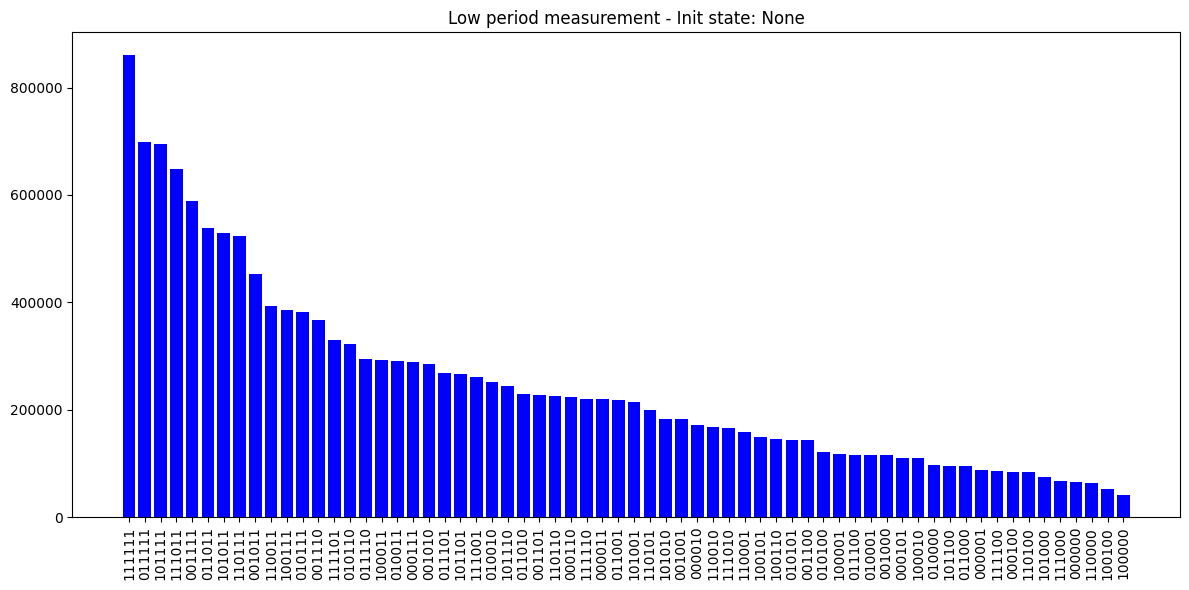

In [14]:
error_vis = ErrorVisualizer(error_obj=errors_obj)
period = "low"
labels, values = error_vis.get_states_histogram(period, obj=0)

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
error_vis.plot_histogram(labels, values, ax=ax1, title=f"{period.capitalize()} period measurement - Init state: {error_vis.init_state}")
plt.tight_layout()
plt.show()

[INFO] Bins before cut: 64
[INFO] Bins after cut: 64


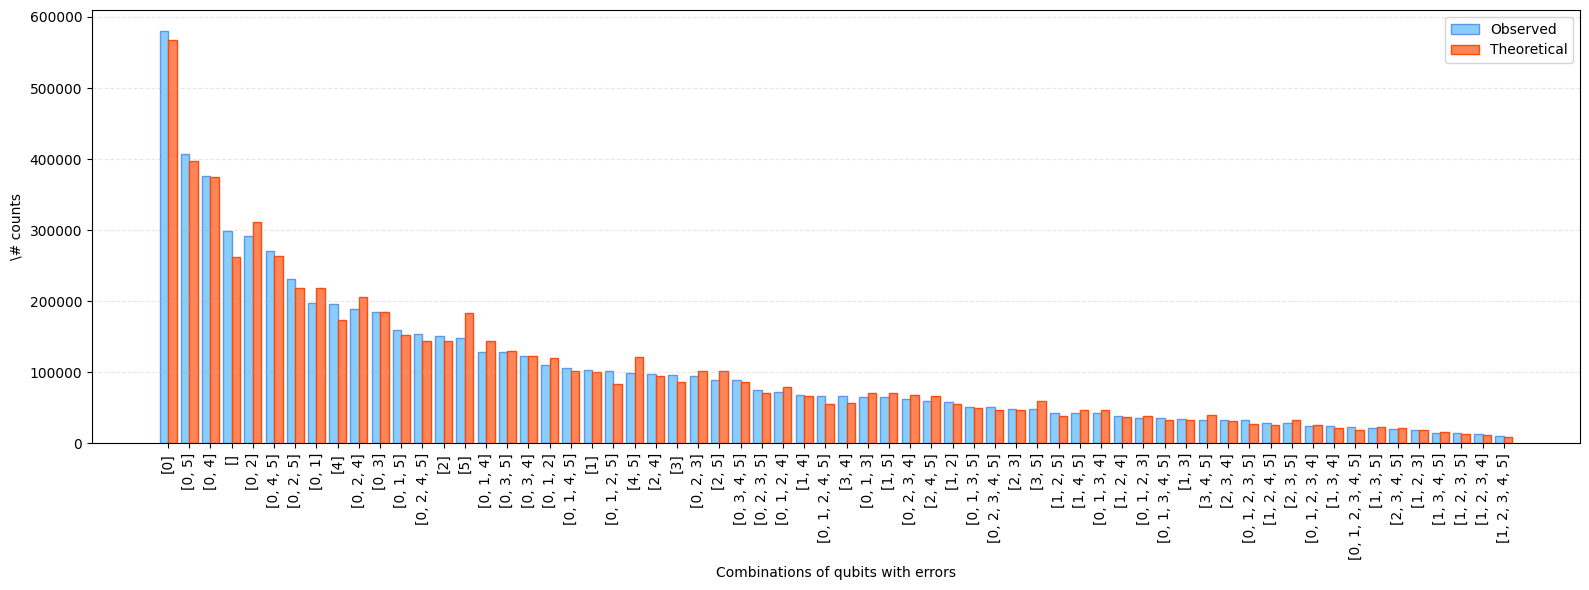

In [15]:
labels_both, observed_counts, theoretical_counts = error_vis.get_error_patterns(period, type="both", threshold=0.0)

# ---- Superposed Bar Plot ----
x = range(len(labels_both))
width = 0.4

# colors1 : Observed - lawngreen, Theoretical - darkviolet

plt.figure(figsize=(16, 6))
plt.bar([i - width/2 for i in x], observed_counts, width=width, label="Observed", color='lightskyblue', edgecolor='cornflowerblue')
plt.bar([i + width/2 for i in x], theoretical_counts, width=width, label="Theoretical", color='coral',alpha = 0.95, edgecolor='orangered')
plt.xticks(x, labels_both, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel(r"\# counts")
#plt.title("Observed vs Theoretical Uncorrelated Errors")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_patterns_low.pdf", format='pdf')
plt.show()

In [16]:
total_errors, true_errors, false_errors = error_vis.get_error_counts(period)

True errors: If a 0 measurement is expected and instead we measure a 1.
False errors:  If a 1 measurement is expected and instead we measure a 0.
Number of true errors: 11134021
Number of false errors 4707769


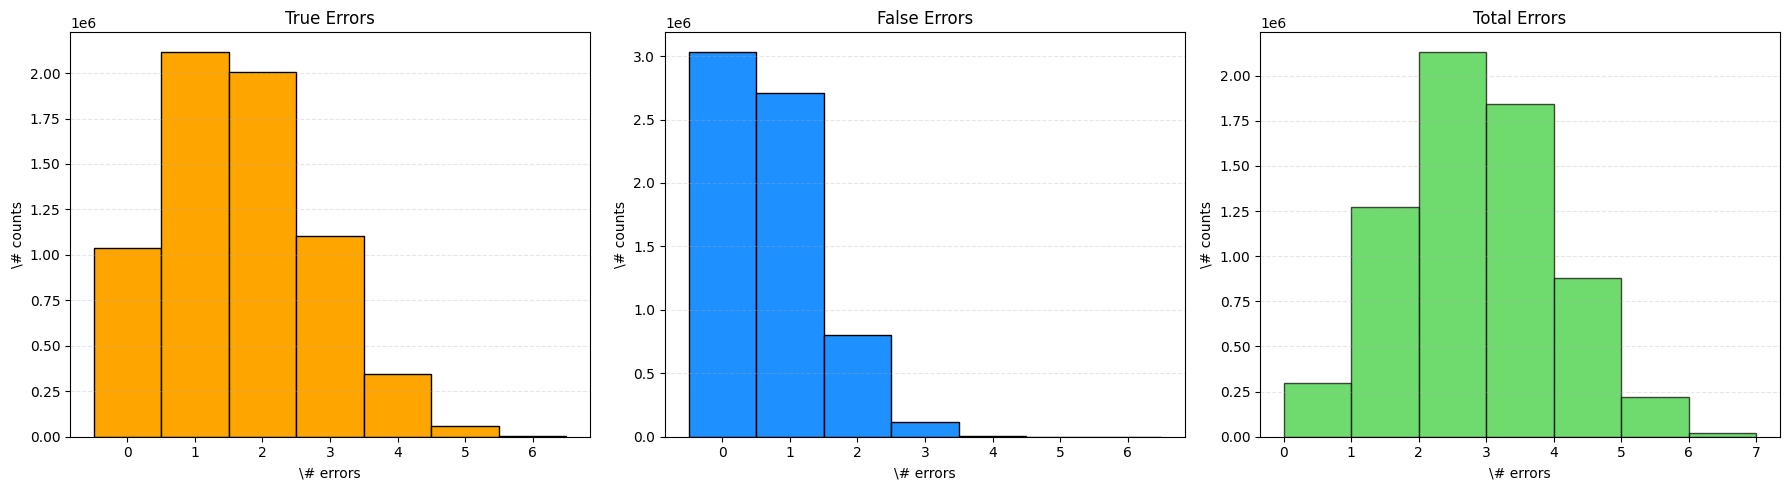

In [17]:
print("True errors: If a 0 measurement is expected and instead we measure a 1.")
print("False errors:  If a 1 measurement is expected and instead we measure a 0.")

print('Number of true errors:',sum(true_errors))
print('Number of false errors', sum(false_errors))

plt.figure(figsize=(18, 5))

    # Histograma de True Errors
plt.subplot(1, 3, 1)
plt.hist(true_errors, bins=range(max(true_errors)+2), edgecolor='black', align='left', color='orange')
plt.title("True Errors")
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Histograma de False Errors
plt.subplot(1, 3, 2)
plt.hist(false_errors, bins=range(max(false_errors)+2), edgecolor='black', align='left', color='dodgerblue')
plt.title("False Errors")
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")

plt.grid(axis='y', linestyle='--', alpha=0.3)


plt.subplot(1,3,3)
plt.hist(total_errors, bins=range(min(total_errors), max(total_errors) + 2), color='limegreen', alpha=0.7, edgecolor='black')
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.title("Total Errors")
#plt.xticks(range(min(total_errors), max(total_errors) + 1))  # Asegurar que los ticks sean enteros
#plt.show()
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_histograms_low.pdf", format='pdf')
plt.show()

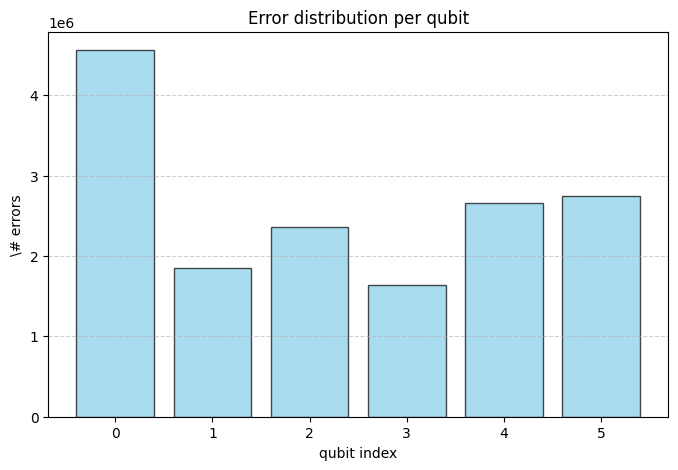

In [18]:
errors_per_qubit = errors_dict["low_period_errors"]["errors_per_qubit"]

# Graficar
plt.figure(figsize=(8, 5))
plt.bar(range(len(errors_per_qubit)), errors_per_qubit, color='skyblue', alpha=0.7, edgecolor='black')

# Etiquetas
plt.xlabel("qubit index")
plt.ylabel(r"\# errors")
plt.title("Error distribution per qubit")
plt.xticks(range(len(errors_per_qubit)))  # Marcamos los qubits en el eje X
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## **Possible cosmic ray impact ?**

In [19]:
# center index
t_center = 90.535

errors_obj_sel = ErrorAnalyzer(repetition_period = rep, init_state = init, measurements = bits, verbose=0, 
                               center_time=t_center, window=(-0.003, 0.007))
error_vis_sel = ErrorVisualizer(errors_obj_sel)

In [20]:
errors_dict_sel = errors_obj_sel.get_errors()

states_sel = errors_dict_sel["low_period_errors"]["states"]
total_errors_sel = errors_dict_sel['low_period_errors']['total_errors']
times_sel = errors_dict_sel['low_period_errors']['times']

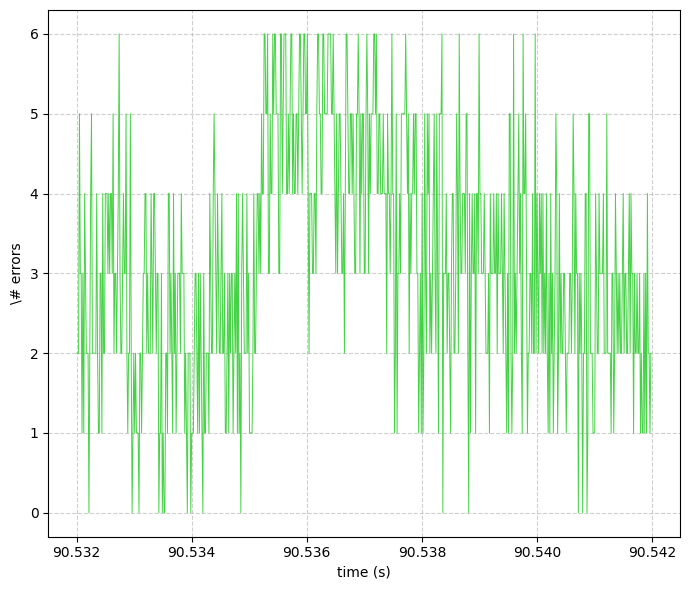

In [21]:
plt.figure(figsize=(7,6))

plt.plot(times_sel, total_errors_sel, '-', color = 'limegreen', linewidth=0.7, alpha=0.9)

plt.xlabel("time (s)")
plt.ylabel(r"\# errors")
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
#plt.savefig("cr_low_11.pdf", format='pdf')
plt.show()

[INFO] Bins before cut: 64
[INFO] Bins after cut: 64


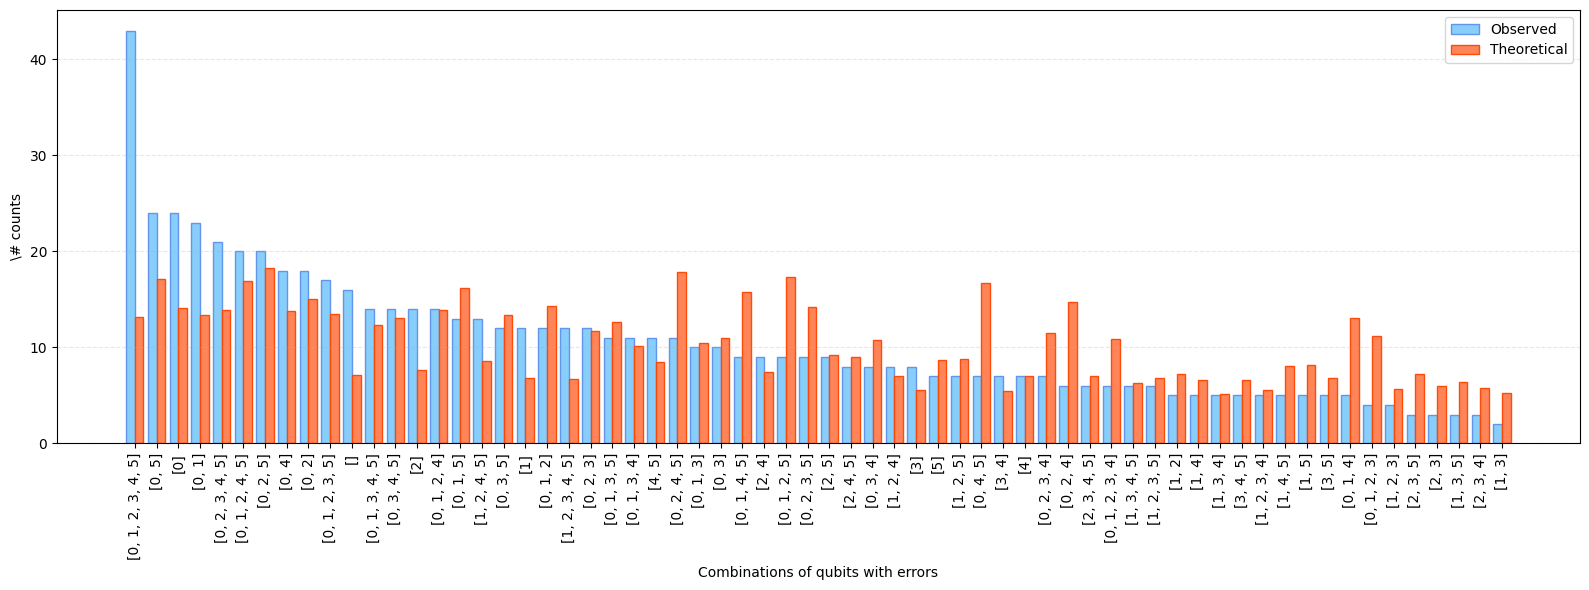

In [22]:
labels_both, observed_counts, theoretical_counts = error_vis_sel.get_error_patterns(period='low', type="both", threshold=0.0)

# ---- Superposed Bar Plot ----
x = range(len(labels_both))
width = 0.4

plt.figure(figsize=(16, 6))
plt.bar([i - width/2 for i in x], observed_counts, width=width, label="Observed", color='lightskyblue', edgecolor='cornflowerblue')
plt.bar([i + width/2 for i in x], theoretical_counts, width=width, label="Theoretical", color='coral',alpha = 0.95, edgecolor='orangered')
plt.xticks(x, labels_both, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel(r"\# counts")
#plt.title("Observed vs Theoretical Uncorrelated Errors")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_patterns_low_cr.pdf", format='pdf')
plt.show()


In [23]:
total_errors_sel, true_errors_sel, false_errors_sel = error_vis_sel.get_error_counts(period='low')

True errors: If a 0 measurement is expected and instead we measure a 1.
False errors:  If a 1 measurement is expected and instead we measure a 0.
Number of true errors: 705
Number of false errors 1391


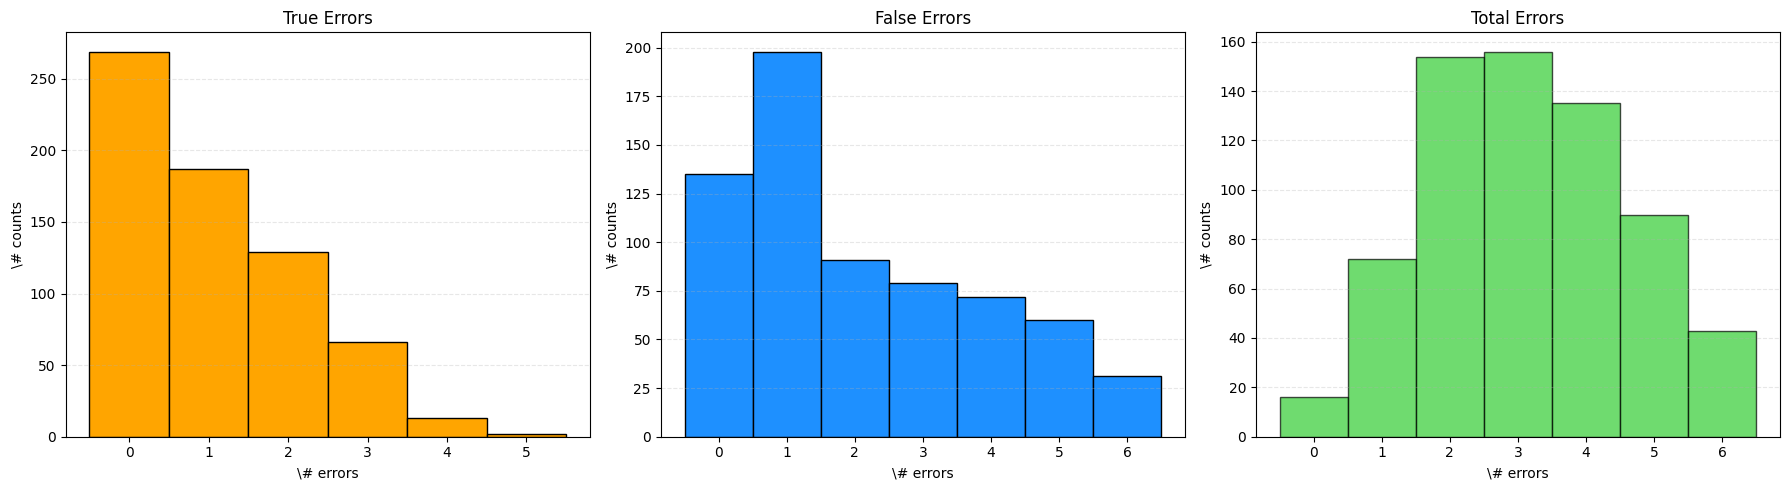

In [24]:
print("True errors: If a 0 measurement is expected and instead we measure a 1.")
print("False errors:  If a 1 measurement is expected and instead we measure a 0.")

print('Number of true errors:',sum(true_errors_sel))
print('Number of false errors', sum(false_errors_sel))


plt.figure(figsize=(18, 5))

    # Histograma de True Errors
plt.subplot(1, 3, 1)
plt.hist(true_errors_sel, bins=range(max(true_errors_sel)+2), edgecolor='black', align='left', color='orange')
plt.title("True Errors")
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Histograma de False Errors
plt.subplot(1, 3, 2)
plt.hist(false_errors_sel, bins=range(max(false_errors_sel)+2), edgecolor='black', align='left', color='dodgerblue')
plt.title("False Errors")
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.3)


plt.subplot(1,3,3)
plt.hist(total_errors_sel, bins=range(max(total_errors_sel) + 2), color='limegreen', align='left', alpha=0.7, edgecolor='black')
plt.title("Total Errors")
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.3)
#plt.xticks(range(min(total_errors), max(total_errors) + 1))  # Asegurar que los ticks sean enteros
#plt.show()
plt.tight_layout()
if output_graphs:   
    plt.savefig("error_histograms_low_cr.pdf", format='pdf')
plt.show()


## **High period circuit.**

### **1. Initial state: $\ket{1}$**

In [25]:
bits_high_1, rep_high_1, init, backend_high_1, extra_high_1 = read_data("data/results_cosmic_high_period.txt")

In [26]:
print("Bitstrings:", bits_high_1[:5])     # first 5 measured states
print("Repetition period:", rep_high_1)
print("Init state:", init)
print("Backend:", backend_high_1)
print("Batch IDs:", extra_high_1.get("batch"))
print("Shot IDs:", extra_high_1.get("shot"))
print("Abs times:", extra_high_1.get("abstime"))


Bitstrings: ['111000' '111111' '011011' '101001' '100001']
Repetition period: 0.00015
Init state: None
Backend: qmio
Batch IDs: [ 1  1  1 ... 83 83 83]
Shot IDs: [     1      2      3 ... 679934 679935 679936]
Abs times: [  1.944018   1.944018   1.944018 ... 162.163034 162.163034 162.163034]


In [27]:
errors_obj_high = ErrorAnalyzer(repetition_period = rep_high_1, init_state = 1, measurements = bits_high_1, threshold=0.000120, verbose=2)
errors_dict_high = errors_obj_high.get_errors()

The analysis was performed using the *high repetition period* approach 
(repetition_period ≥ 1.2e-10 μs). The error dictionary contains:

- Key: 'high_period_errors' → Returns two arrays with 679936 measurements:
  - 'error_counts': Array with the number of errors associated with each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).




In [28]:
states_high = errors_dict_high["high_period_errors"]["states"]
total_errors_high = errors_dict_high['high_period_errors']['total_errors']
times_high = errors_dict_high['high_period_errors']['times']

print('number of total errors:',sum(total_errors_high))


number of total errors: 797462


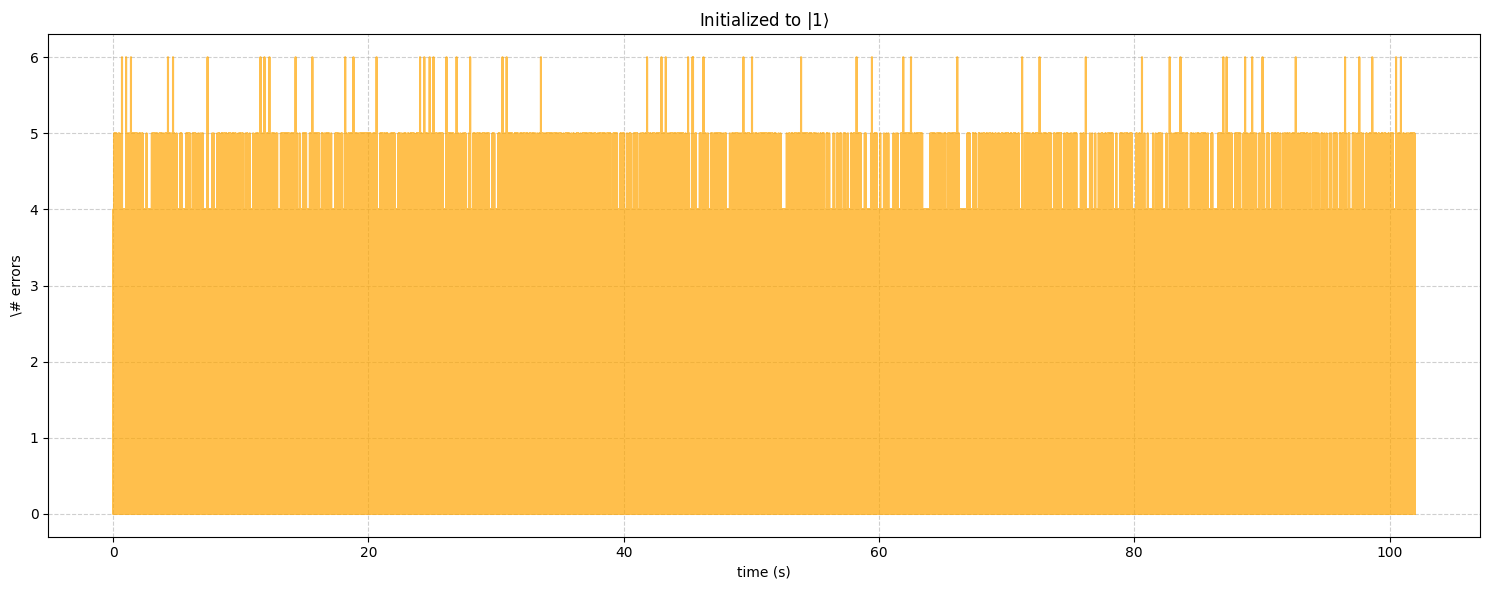

In [29]:
plt.figure(figsize=(15,6))

plt.plot(times_high, total_errors_high, '-', color = 'orange', markersize=3, alpha=0.7)

plt.xlabel("time (s)")
plt.ylabel(r"\# errors")
plt.grid(True, linestyle='--', alpha=0.6)
plt.title(r'Initialized to $|1\rangle$')

plt.tight_layout()
plt.show()

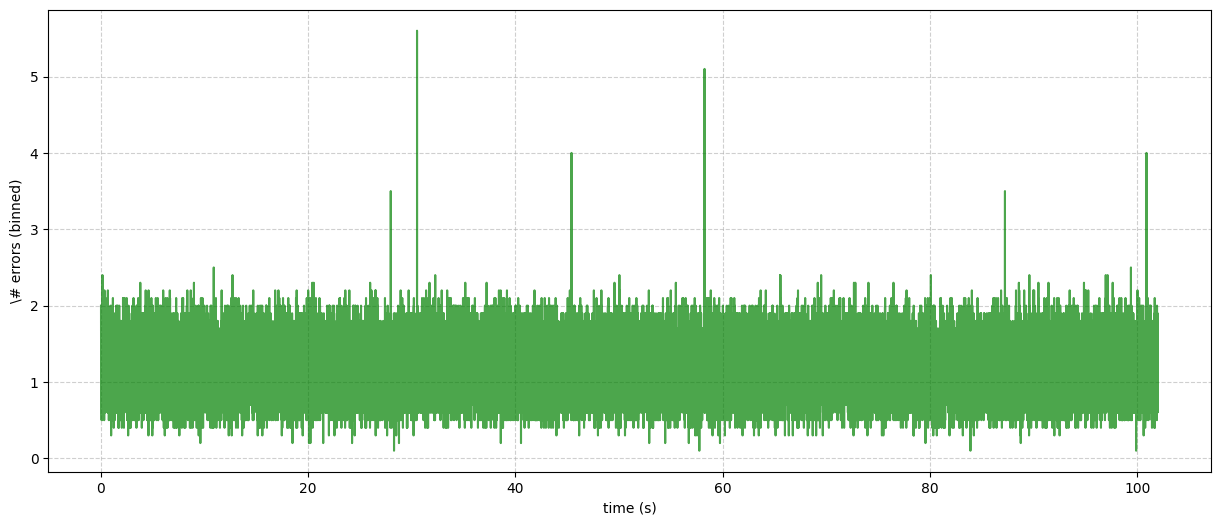

In [30]:
# Example: group every 6 points
bin_size = 10

# convert to arrays
times_high = np.array(times_high)
total_errors_high = np.array(total_errors_high)

# number of full bins
n_bins = len(total_errors_high) // bin_size

# reshape and take mean
binned_times = times_high[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)
binned_errors = total_errors_high[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)

# plot
plt.figure(figsize=(15,6))
plt.plot(binned_times, binned_errors, '-', color='green', alpha=0.7)
plt.xlabel("time (s)")
plt.ylabel(r"\# errors (binned)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

mean number of errors: 1.1728472048593235


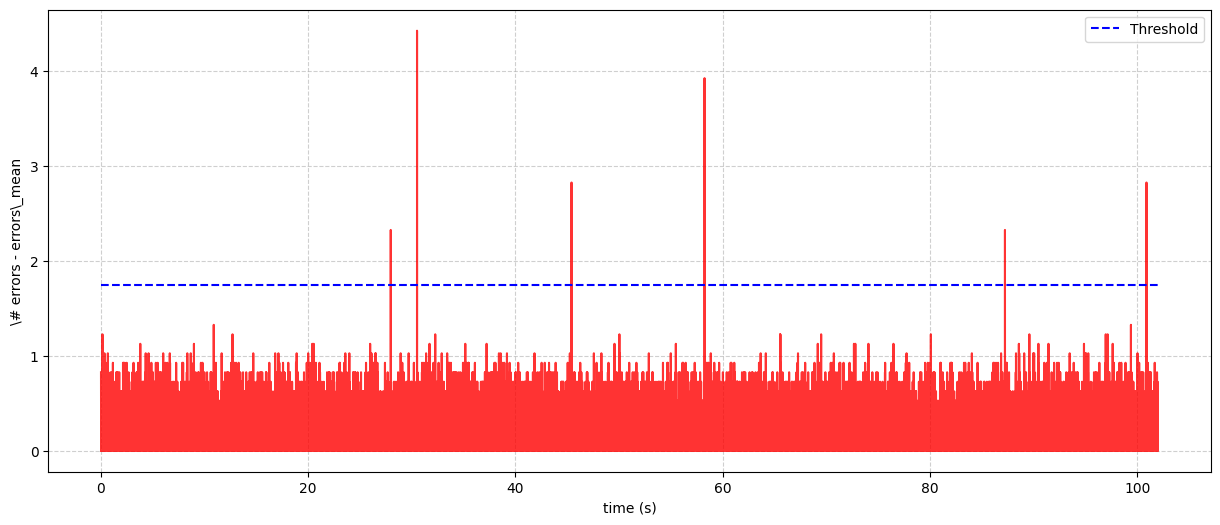

In [31]:
# assume binned_times, binned_errors from previous step
# ---------------- BASELINE ----------------
baseline = np.mean(binned_errors)  # or np.median(binned_errors)
signal = binned_errors - baseline  # subtract baseline
print('mean number of errors:', baseline)

# optionally clip negatives to zero (if you only care about positive peaks)
signal = np.clip(signal, 0, None)
threshold = 1.75

# ---------------- PLOT ----------------
plt.figure(figsize=(15,6))
plt.plot(binned_times, signal, '-', color='red', alpha=0.8)
plt.xlabel("time (s)")
plt.ylabel(r"\# errors - errors\_mean")
plt.hlines(y=threshold, xmin=binned_times[0], xmax=binned_times[-1], color='blue', linestyle='--', label='Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
if output_graphs:  
    plt.savefig("errors_time_high_1.pdf", format='pdf')
plt.show()

In [32]:
# ---------------- PARAMETERS ----------------
threshold = 1.75
window_before = 0.1  # seconds
window_after  = 0.3  # seconds

# ---------------- FIND PEAKS ON BINNED SIGNAL ----------------
peak_indices = np.where(signal > threshold)[0]

# avoid duplicates if consecutive bins are above threshold
selected_peaks = []
for idx in peak_indices:
    if not selected_peaks or (idx - selected_peaks[-1]) > 1:
        selected_peaks.append(idx)

print(f"Found {len(selected_peaks)} candidate peaks")

# ---------------- EXTRACT FROM RAW DATA ----------------
for peak_idx in selected_peaks:
    t_peak = binned_times[peak_idx]
    print(f"Peak at t = {t_peak:.3f} s")
    
    # define window in raw times
    t_min = t_peak - window_before
    t_max = t_peak + window_after
    
    # mask on raw data
    mask = (times_high >= t_min) & (times_high <= t_max)

    # plot raw errors around peak
    # plt.figure(figsize=(10,4))
    # plt.plot(times_high[mask], total_errors_high[mask], 'o-', color='purple')
    # plt.axhline(np.mean(total_errors_high), color='gray', linestyle='--', alpha=0.7, label="mean noise")
    # plt.axvline(t_peak, color='black', linestyle=':', label="peak")
    # plt.xlabel("time (s)")
    # plt.ylabel(r"\# errors (raw)")
    # plt.title(f"Raw errors around peak at t = {t_peak:.3f} s")
    # plt.legend()
    # plt.grid(True, linestyle='--', alpha=0.6)
    # plt.show()

Found 7 candidate peaks
Peak at t = 27.964 s
Peak at t = 30.500 s
Peak at t = 30.503 s
Peak at t = 45.409 s
Peak at t = 58.246 s
Peak at t = 87.238 s
Peak at t = 100.895 s


The analysis was performed using the *high repetition period* approach 
(repetition_period ≥ 1.2e-10 μs). The error dictionary contains:

- Key: 'high_period_errors' → Returns two arrays with 679936 measurements:
  - 'error_counts': Array with the number of errors associated with each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).




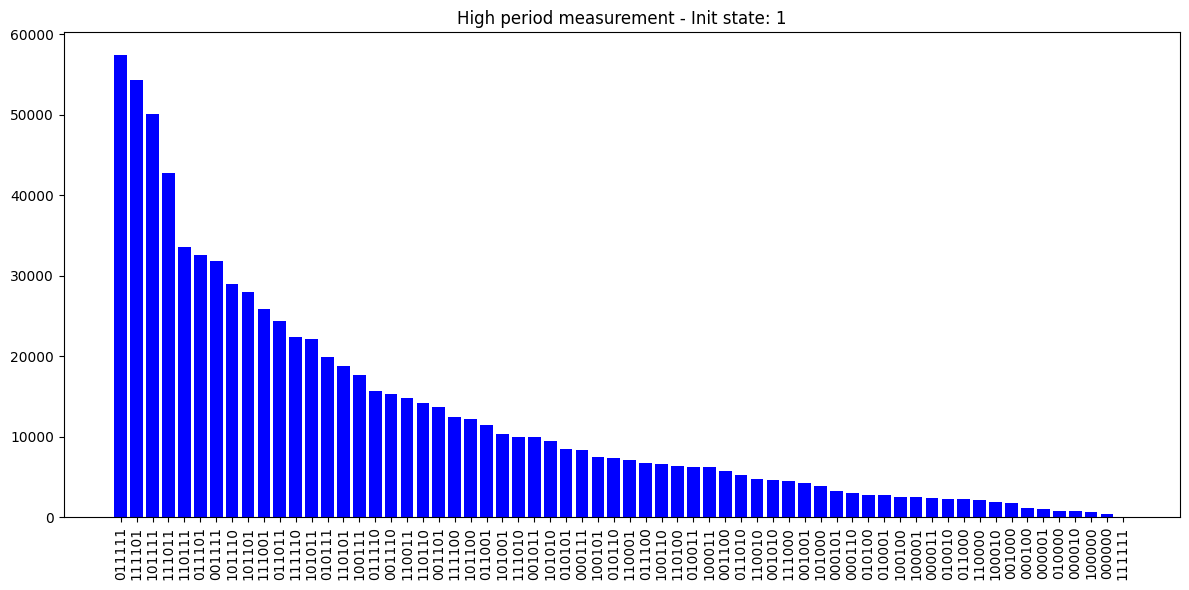

In [33]:
error_vis_high = ErrorVisualizer(error_obj=errors_obj_high)
period = "high"
labels, values = error_vis_high.get_states_histogram(period, obj=0)

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
error_vis_high.plot_histogram(labels, values, ax=ax1, title=f"{period.capitalize()} period measurement - Init state: {error_vis_high.init_state}")
plt.tight_layout()
plt.show()

[INFO] Bins before cut: 64
[INFO] Bins after cut: 64


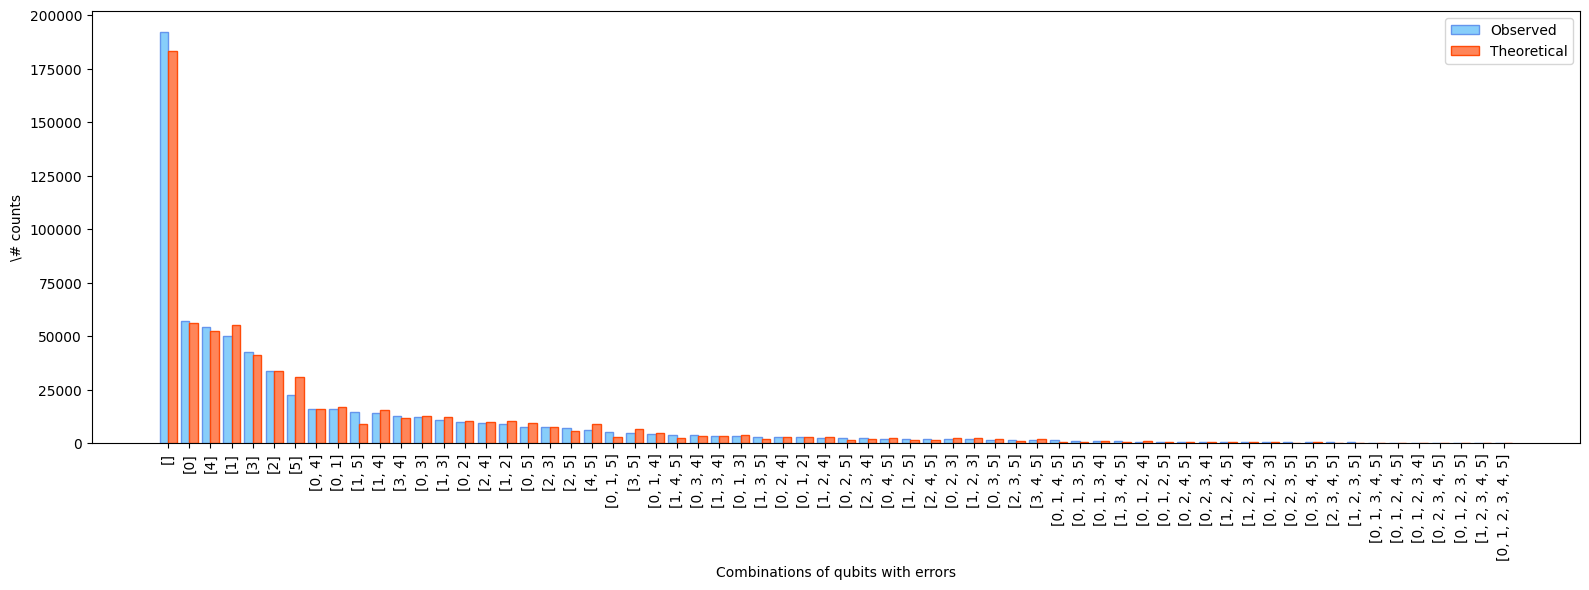

In [34]:
labels_both, observed_counts, theoretical_counts = error_vis_high.get_error_patterns(period, type="both", threshold=0.0)

# ---- Superposed Bar Plot ----
x = range(len(labels_both))
width = 0.4

plt.figure(figsize=(16, 6))
plt.bar([i - width/2 for i in x], observed_counts, width=width, label="Observed", color='lightskyblue', edgecolor='cornflowerblue')
plt.bar([i + width/2 for i in x], theoretical_counts, width=width, label="Theoretical", color='coral',alpha = 0.95, edgecolor='orangered')
plt.xticks(x, labels_both, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel(r"\# counts")
#plt.title("Observed vs Theoretical Uncorrelated Errors")
plt.legend()
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_patterns_high.pdf", format='pdf')
plt.show()

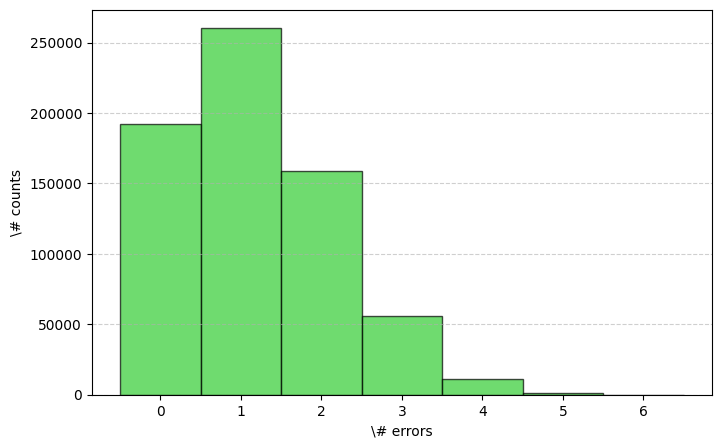

In [35]:
plt.figure(figsize=(8,5))
plt.hist(total_errors_high, bins=range(max(total_errors_high) + 2), align='left', color='limegreen', alpha=0.7, edgecolor='black')
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.6)
if output_graphs:  
    plt.savefig("error_histogram_high_1.pdf", format='pdf')
plt.show()

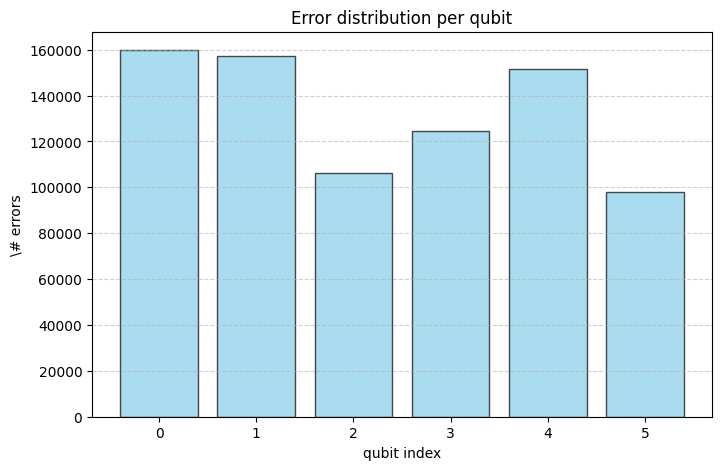

In [36]:
errors_per_qubit = errors_dict_high["high_period_errors"]["errors_per_qubit"]

# Graficar
plt.figure(figsize=(8, 5))
plt.bar(range(len(errors_per_qubit)), errors_per_qubit, color='skyblue', alpha=0.7, edgecolor='black')

# Etiquetas
plt.xlabel("qubit index")
plt.ylabel(r"\# errors")
plt.title("Error distribution per qubit")
plt.xticks(range(len(errors_per_qubit)))  # Marcamos los qubits en el eje X
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### **Posible cosmic ray?**

In [37]:
t = [27.964,30.499,45.409,58.246,87.238,100.897]

index = 1
t_central=t[index]

errors_obj_high_1_sel = ErrorAnalyzer(repetition_period = rep_high_1, init_state = init, measurements = bits_high_1, 
                               verbose=0, threshold=0.000120, center_time=t_central, window=(-0.01, 0.015))
error_vis_high_1_sel = ErrorVisualizer(errors_obj_high_1_sel)
# now compute error patterns from this subset

In [38]:
errors_dict_high_1_sel = errors_obj_high_1_sel.get_errors()

states_high_1_sel = errors_dict_high_1_sel["high_period_errors"]["states"]
total_errors_high_1_sel = errors_dict_high_1_sel['high_period_errors']['total_errors']
times_high_1_sel = errors_dict_high_1_sel['high_period_errors']['times']


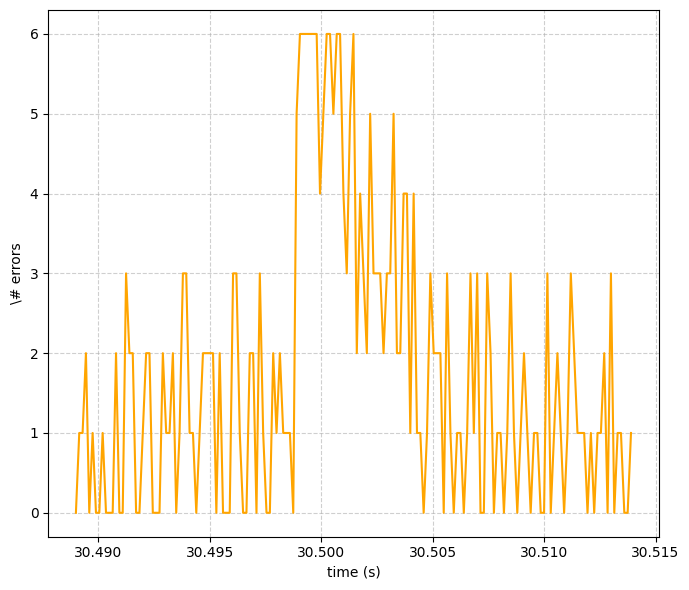

In [39]:
plt.figure(figsize=(7,6))

plt.plot(times_high_1_sel, total_errors_high_1_sel, '-', color = 'orange', markersize=3)

plt.xlabel("time (s)")
plt.ylabel(r"\# errors")
plt.grid(True, linestyle='--', alpha=0.6)
#plt.title(r'Initialized to |1⟩')
plt.tight_layout()
if output_graphs:  
    plt.savefig("cr_high_"+str(index)+".pdf", format='pdf')
plt.show()

[INFO] Bins before cut: 44
[INFO] Bins after cut: 44


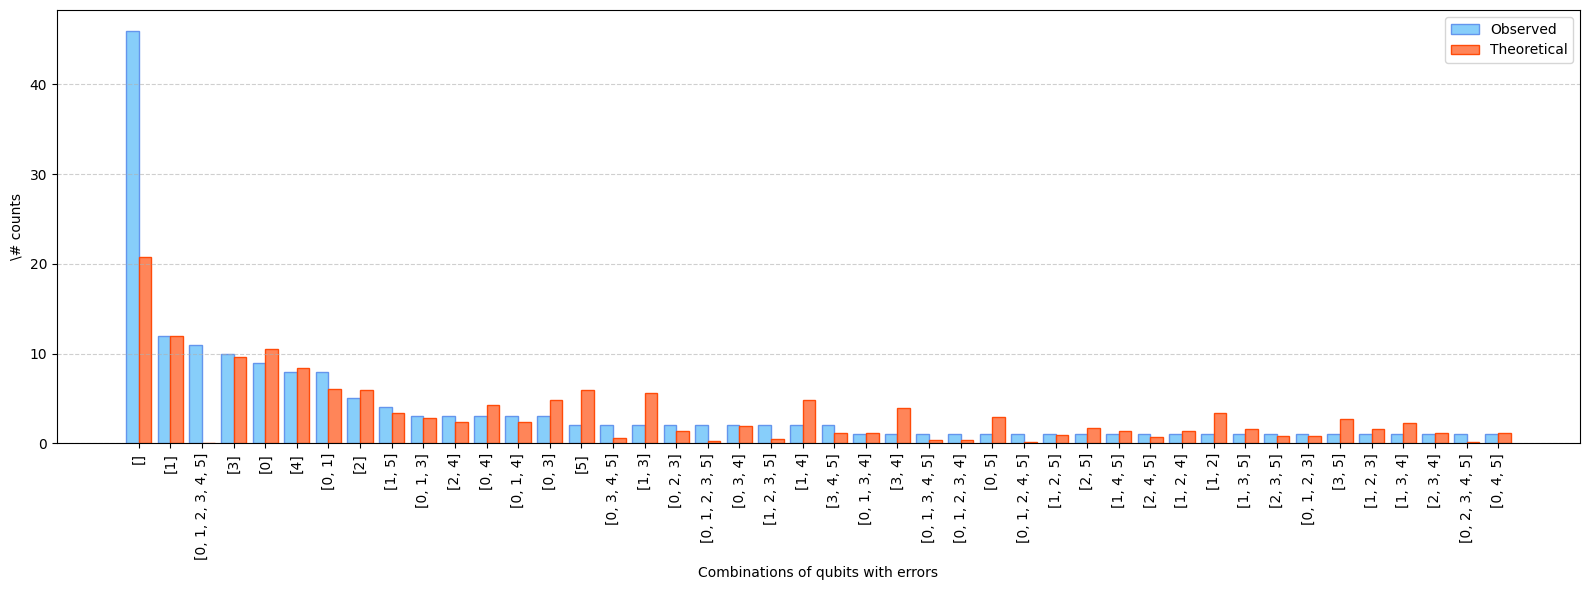

In [40]:
labels_both_1, observed_counts_1, theoretical_counts_1 = error_vis_high_1_sel.get_error_patterns(period, type="both", threshold=0.0)

# ---- Superposed Bar Plot ----
x = range(len(labels_both_1))
width = 0.4

plt.figure(figsize=(16, 6))
plt.bar([i - width/2 for i in x], observed_counts_1, width=width, label="Observed", color='lightskyblue', edgecolor='cornflowerblue')
plt.bar([i + width/2 for i in x], theoretical_counts_1, width=width, label="Theoretical", color='coral',alpha = 0.95, edgecolor='orangered')
plt.xticks(x, labels_both_1, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel(r"\# counts")
#plt.title("Observed vs Theoretical Uncorrelated Errors")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_patterns_high_cr.pdf", format='pdf')
plt.show()

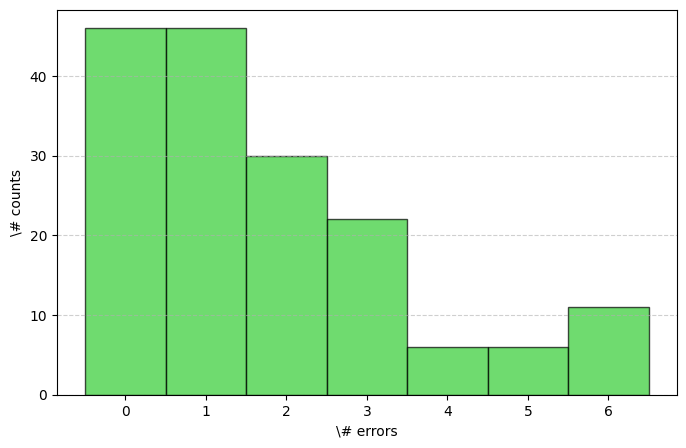

In [41]:
plt.figure(figsize=(8,5))
plt.hist(total_errors_high_1_sel, bins=range(max(total_errors_high_1_sel) + 2), align='left', color='limegreen', alpha=0.7, edgecolor='black')
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.6)
if output_graphs:  
    plt.savefig("error_histogram_high_1_cr.pdf", format='pdf')
plt.show()


### **2. Initial state: $\ket{0}$**

In [42]:
bits_high_0, rep_high_0, init, backend_high_0, extra_high_0 = read_data("data/results_cosmic_high_period_0.txt")

In [43]:
print("Bitstrings:", bits_high_0[:5])     # first 5 measured states
print("Repetition period:", rep_high_0)
print("Init state:", init)
print("Backend:", backend_high_0)
print("Batch IDs:", extra_high_0.get("batch"))
print("Shot IDs:", extra_high_0.get("shot"))
print("Abs times:", extra_high_0.get("abstime"))


Bitstrings: ['000000' '000000' '000000' '100001' '100011']
Repetition period: 0.00015
Init state: None
Backend: qmio
Batch IDs: [ 1  1  1 ... 83 83 83]
Shot IDs: [     1      2      3 ... 679934 679935 679936]
Abs times: [  1.914298   1.914298   1.914298 ... 158.527913 158.527913 158.527913]


In [44]:
errors_obj_high_0 = ErrorAnalyzer(repetition_period = rep_high_0, init_state = 0, 
                                  measurements = bits_high_0, threshold=0.000120, verbose=2)
errors_dict_high_0 = errors_obj_high_0.get_errors()

The analysis was performed using the *high repetition period* approach 
(repetition_period ≥ 1.2e-10 μs). The error dictionary contains:

- Key: 'high_period_errors' → Returns two arrays with 679936 measurements:
  - 'error_counts': Array with the number of errors associated with each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).




In [45]:
states_high_0 = errors_dict_high_0["high_period_errors"]["states"]
total_errors_high_0 = errors_dict_high_0['high_period_errors']['total_errors']
times_high_0 = errors_dict_high_0['high_period_errors']['times']

print('number of total errors:',sum(total_errors_high_0))


number of total errors: 419071


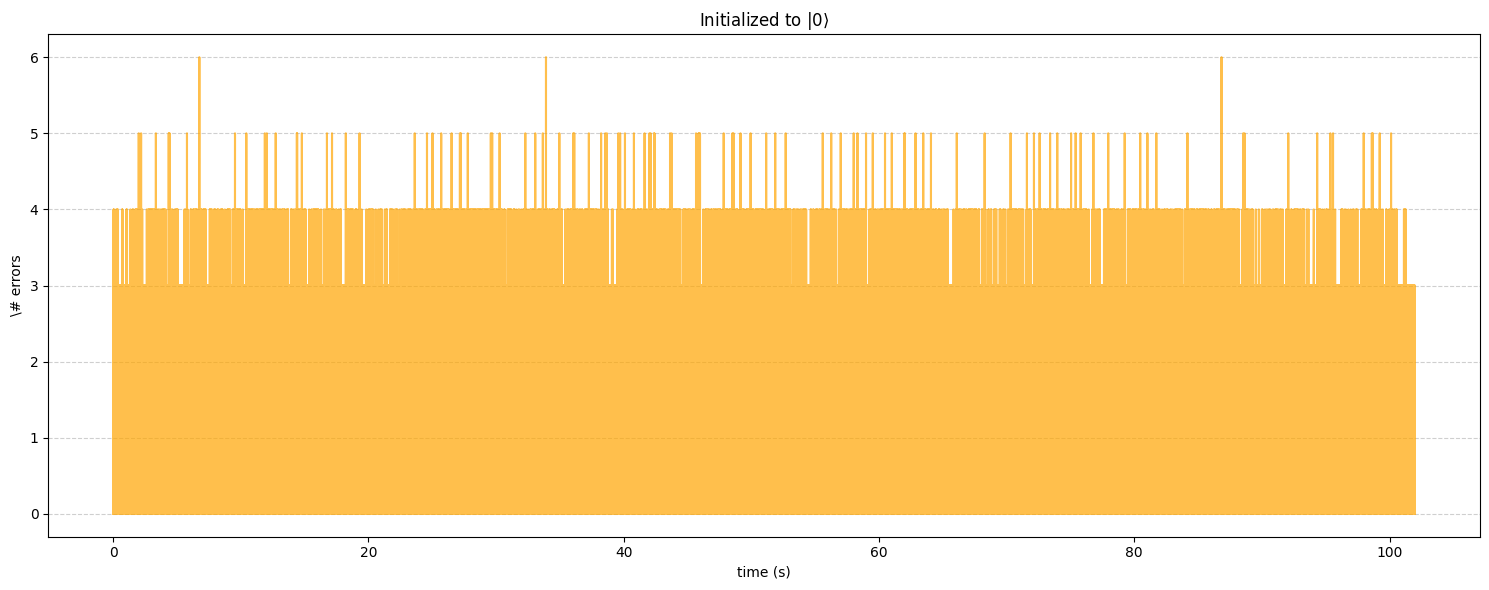

In [46]:
plt.figure(figsize=(15,6))

plt.plot(times_high_0, total_errors_high_0, '-', color = 'orange', markersize=3, alpha=0.7)

plt.xlabel("time (s)")
plt.ylabel(r"\# errors")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.title(r'Initialized to $|0\rangle$')

plt.tight_layout()
plt.show()

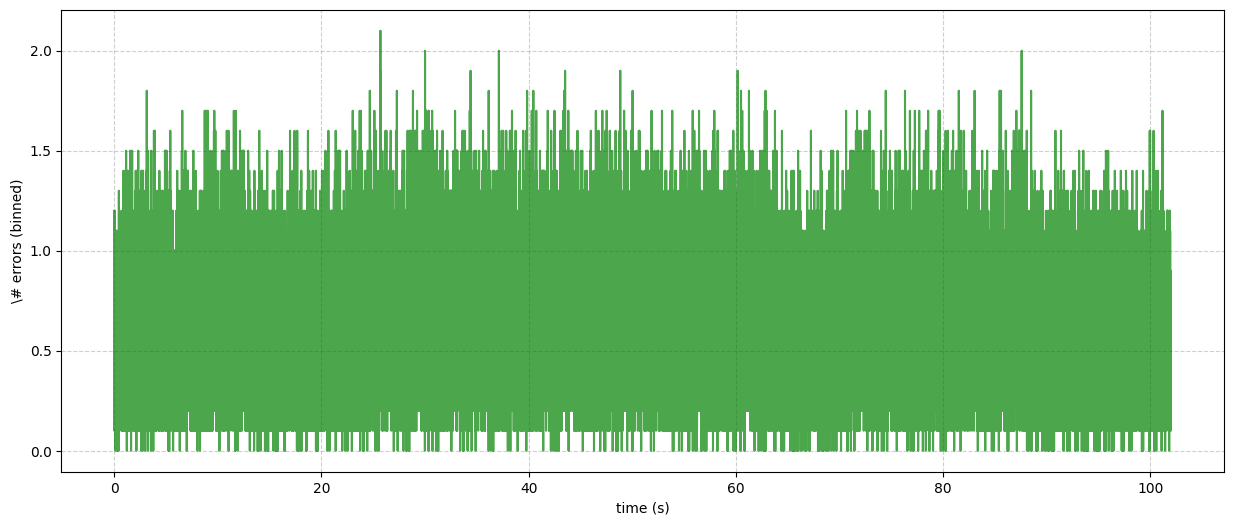

In [47]:
# Example: group every 6 points
bin_size = 10

# convert to arrays
times_high_0 = np.array(times_high_0)
total_errors_high_0 = np.array(total_errors_high_0)

# number of full bins
n_bins = len(total_errors_high_0) // bin_size

# reshape and take mean
binned_times = times_high_0[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)
binned_errors = total_errors_high_0[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)

# plot
plt.figure(figsize=(15,6))
plt.plot(binned_times, binned_errors, '-', color='green', alpha=0.7)
plt.xlabel("time (s)")
plt.ylabel(r"\# errors (binned)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

mean number of errors: 0.6163340343858927


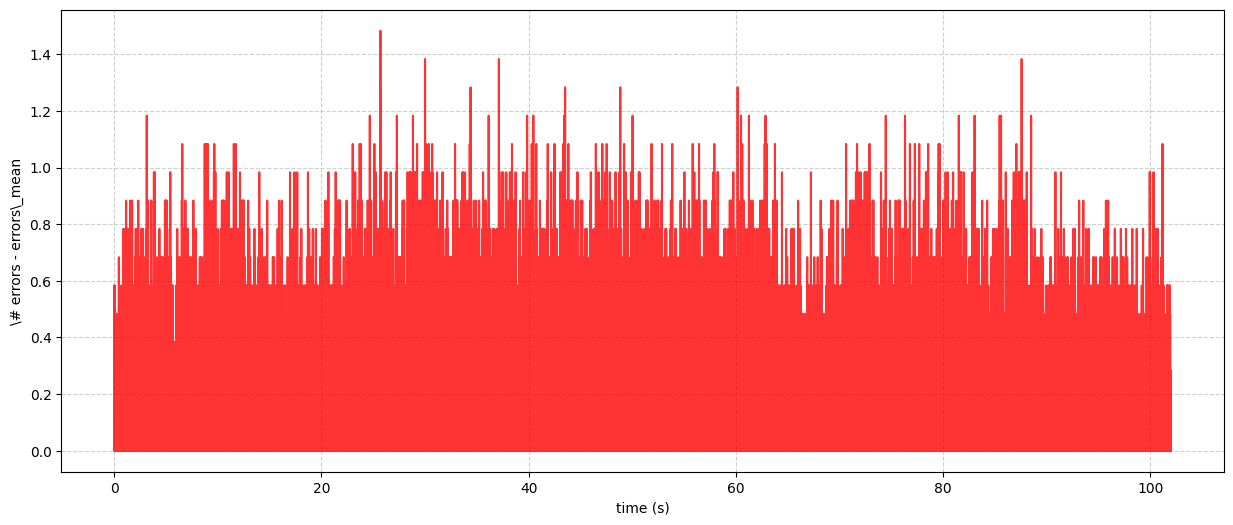

In [48]:
# assume binned_times, binned_errors from previous step
# ---------------- BASELINE ----------------
baseline = np.mean(binned_errors)  # or np.median(binned_errors)
print('mean number of errors:', baseline)
signal = binned_errors - baseline  # subtract baseline

# optionally clip negatives to zero (if you only care about positive peaks)
signal = np.clip(signal, 0, None)

# ---------------- PLOT ----------------
plt.figure(figsize=(15,6))
plt.plot(binned_times, signal, '-', color='red', alpha=0.8)
plt.xlabel("time (s)")
plt.ylabel(r"\# errors - errors\_mean")
plt.grid(True, linestyle='--', alpha=0.6)
if output_graphs:  
    plt.savefig("errors_time_high_0.pdf", format='pdf')
plt.show()

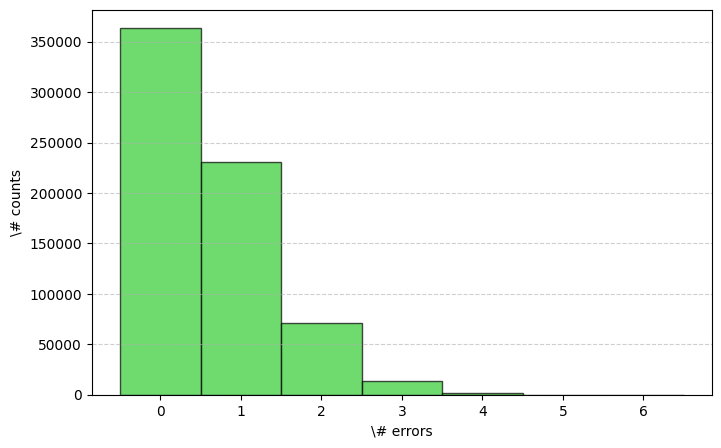

In [49]:
plt.figure(figsize=(8,5))
plt.hist(total_errors_high_0, bins=range(max(total_errors_high_0) + 2), align='left', color='limegreen', alpha=0.7, edgecolor='black')
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.6)
if output_graphs:  
    plt.savefig("error_histogram_high_0.pdf", format='pdf')
plt.show()